[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PGM-Lab/pidsia/blob/master/notebooks/NLPCA.ipynb)

# Non-Linear PCA example in InferPy
<br/><br/>


![PCA Example](https://raw.githubusercontent.com/PGM-Lab/public-files/master/aux/inferpy/img/nlpca2.png)

<br/><br/>

## Requiered packages

First, we install inferpy from PyPi:

In [4]:
!pip install inferpy

Import some packages:

In [5]:
import inferpy as inf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from inferpy.datasets import mnist

tf.reset_default_graph()


print(inf.__version__)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.0.0


Using TensorFlow backend.


## Data
For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the `inferpy.datasets.mnist`:

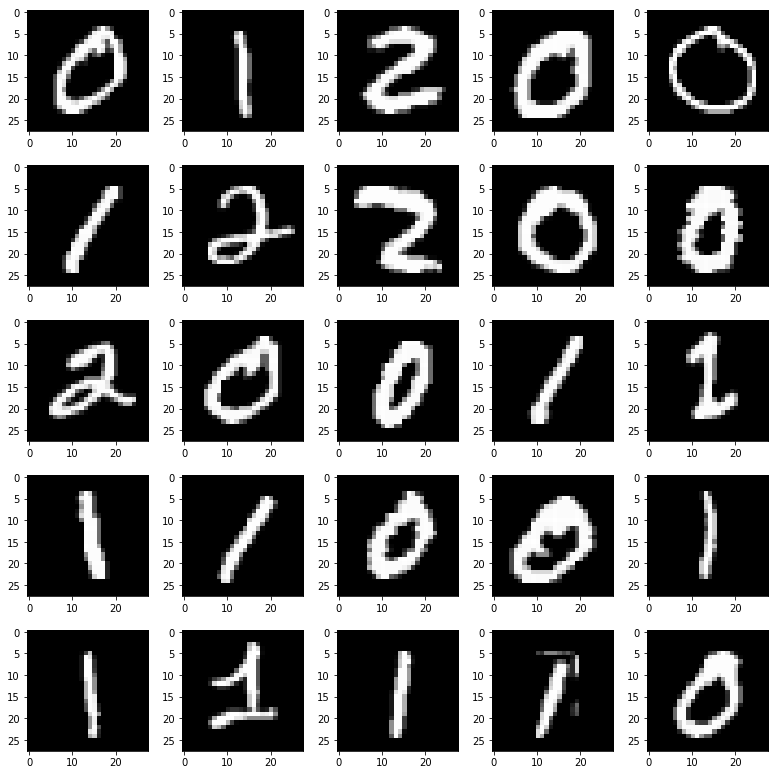

In [6]:
(x_train, y_train), _ = mnist.load_data(num_instances=1000, digits=[0,1,2])

mnist.plot_digits(x_train, grid =[5,5] )

## Model definition

The PPL implementig a PCA is shown below together with the correspondig Q-model for making variational inference.

In [7]:
# number of components
k = 2
# size of the hidden layer in the NN
d0 = 100
# dimensionality of the data
dx = 28*28

scale_epsilon = 0.01


@inf.probmodel
def nlpca(k, d0, dx, decoder):
    with inf.datamodel():
        z = inf.Normal(tf.ones([k]) * 0.1, 1., name="z")  # shape = [N,k]
        output = decoder(z, d0, dx)
        x_loc = output[:, :dx]
        x_scale = tf.nn.softmax(output[:, dx:]) + scale_epsilon
        x = inf.Normal(x_loc, x_scale, name="x")  # shape = [N,d]


def decoder(z, d0, dx):  # k -> d0 -> 2*dx
    h0 = tf.layers.dense(z, d0, tf.nn.relu)
    return tf.layers.dense(h0, 2 * dx)


@inf.probmodel
def qmodel(k):
    with inf.datamodel():
        qz_loc = inf.Parameter(np.ones([k])*0.1, name="qz_loc")
        qz_scale = tf.math.softmax(inf.Parameter(tf.ones([k]), name="qz_scale"))
        qz = inf.Normal(qz_loc, qz_scale, name="z")




m = nlpca(k, d0, dx, decoder)
q = qmodel(k)
print(m)
print(q)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


## Inference

We define the optimizer, the inference method VI and start it:

In [8]:
# set the inference algorithm
VI = inf.inference.VI(q, epochs=5000)
# learn the parameters
m.fit({"x": x_train}, VI)


 0 epochs	 22788266000384.0....................
 200 epochs	 15484335423488.0....................
 400 epochs	 13930114056192.0....................
 600 epochs	 11586655748096.0....................
 800 epochs	 10100727087104.0....................
 1000 epochs	 9216063438848.0....................
 1200 epochs	 8499686801408.0....................
 1400 epochs	 8014060322816.0....................
 1600 epochs	 7683367239680.0....................
 1800 epochs	 7471479390208.0....................
 2000 epochs	 7219811713024.0....................
 2200 epochs	 7061251293184.0....................
 2400 epochs	 6916020895744.0....................
 2600 epochs	 6776236802048.0....................
 2800 epochs	 6656472645632.0....................
 3000 epochs	 6584460115968.0....................
 3200 epochs	 6503264157696.0....................
 3400 epochs	 6384153264128.0....................
 3600 epochs	 6281061466112.0....................
 3800 epochs	 6179103178752.0....................
 

OrderedDict([('z',
              <inf.RandomVariable (Normal distribution) named z_2/, shape=(1000, 2), dtype=float32>)])

The evolution of the loss function can be seen below

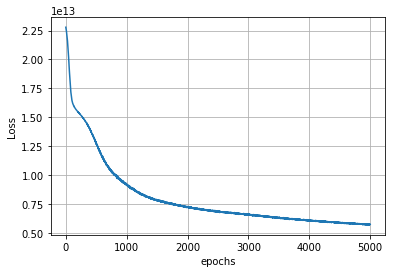

In [9]:
L = VI.losses
plt.plot(range(len(L)), L)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

After the inference, we can extract the posterior distribution of the non-observed variables. In this case, we might be interested in the posterior of `z`, which is the hidden representation of our observations.

In [10]:
#extract the hidden encoding
sess = inf.get_session()
post = {"z" : sess.run(m.posterior["z"].loc)}

By plotting this hidden representaiton, we observe that points corresponding to the same digit remain together. 

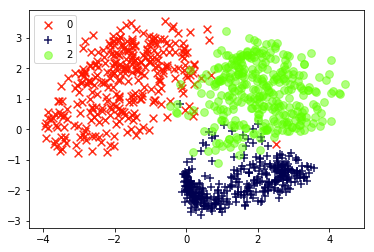

In [11]:

# plot
markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()
DIG = [0,1,2]

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()

plt.show()


Finally, we can sample from the posterior predictive distribution for generating new images

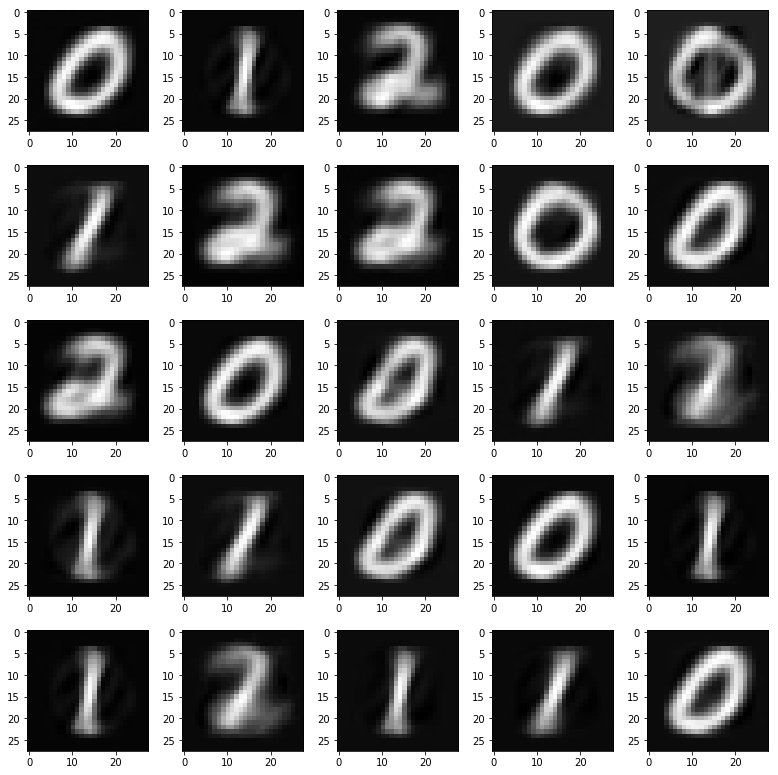

In [12]:
post_samples = m.post_predictive_sample()
mnist.plot_digits(post_samples["x"], grid=[5,5])